In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import joblib

My Project is about predicting Car prices for a chinese company that wants to setup a manufacturing unit in the US.
There are many features affecting the car price like No. of cylinders, horsepower, mileage, enginesize etc.

I will train and test models to findout which feature contributes most for setting the pricing of the car

In [2]:
#Loading the dataset
car_data = pd.read_csv(r"C:\Users\GIFT OF THANKS\OneDrive\Desktop\DS Project Personal\archive\CarPrice_Assignment.csv")

# 1.Basic data exploratory analysis

In [3]:
#Understanding the dataset
print(" Exploratory Data Analysis:")
print("\n Basic Info:")
print(car_data.info())

mean_price = car_data['price'].mean()
std_price = car_data['price'].std()

print(f"Mean car price: {mean_price:.2f}")
print(f"Standard deviation of price: {std_price:.2f}")



 Exploratory Data Analysis:

 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  en

In [4]:
## Checking for missing values and duplicates ##
print("\n Missing Values:")
print(car_data.isnull().sum().sum())
print("\n Duplicates:")
print(car_data.duplicated().sum())

##Dropping 'car_ID' column as it is not useful for prediction##
car_data.drop(columns=['car_ID'], inplace=True)
car_data.head()

## Listing down numeric and categorical columns after dropping car_ID##
print("Numeric Columns:")
print(car_data.describe(include=['int64', 'float64']).shape[1])
print(list(car_data.describe(include=['int64', 'float64']).columns))
print("Categorical Columns:")
print(car_data.describe(include='object').shape[1])
print(list(car_data.describe(include='object').columns))


 Missing Values:
0

 Duplicates:
0
Numeric Columns:
15
['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']
Categorical Columns:
10
['CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']


1.1 Checking correlation for Numeric values

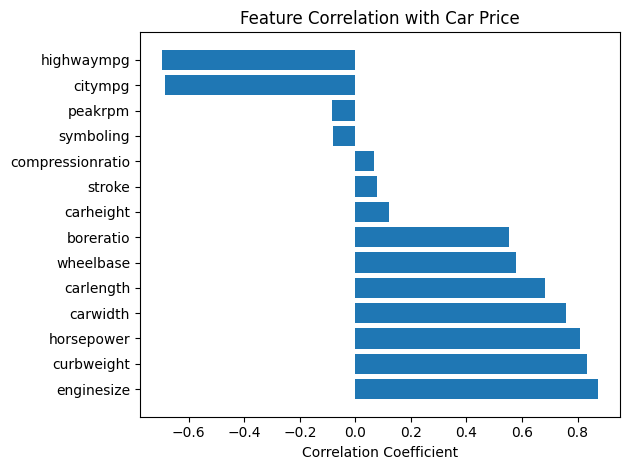

In [5]:
# Defining numerical features (excluding target and car_ID)
numerical_features = [
    'symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
    'curbweight', 'enginesize', 'boreratio', 'stroke',
    'compressionratio', 'horsepower', 'peakrpm',
    'citympg', 'highwaympg'
]

# Compute correlation with target variable (price)
correlations = car_data[numerical_features + ['price']].corr()['price'].sort_values(ascending=False)

# Remove target itself
correlations.drop('price', inplace=True)

plt.figure()
plt.barh(correlations.index, correlations.values)
plt.xlabel('Correlation Coefficient')
plt.title('Feature Correlation with Car Price')
plt.tight_layout()
plt.show()


1.2 Checking the features and target correlation using heatmap

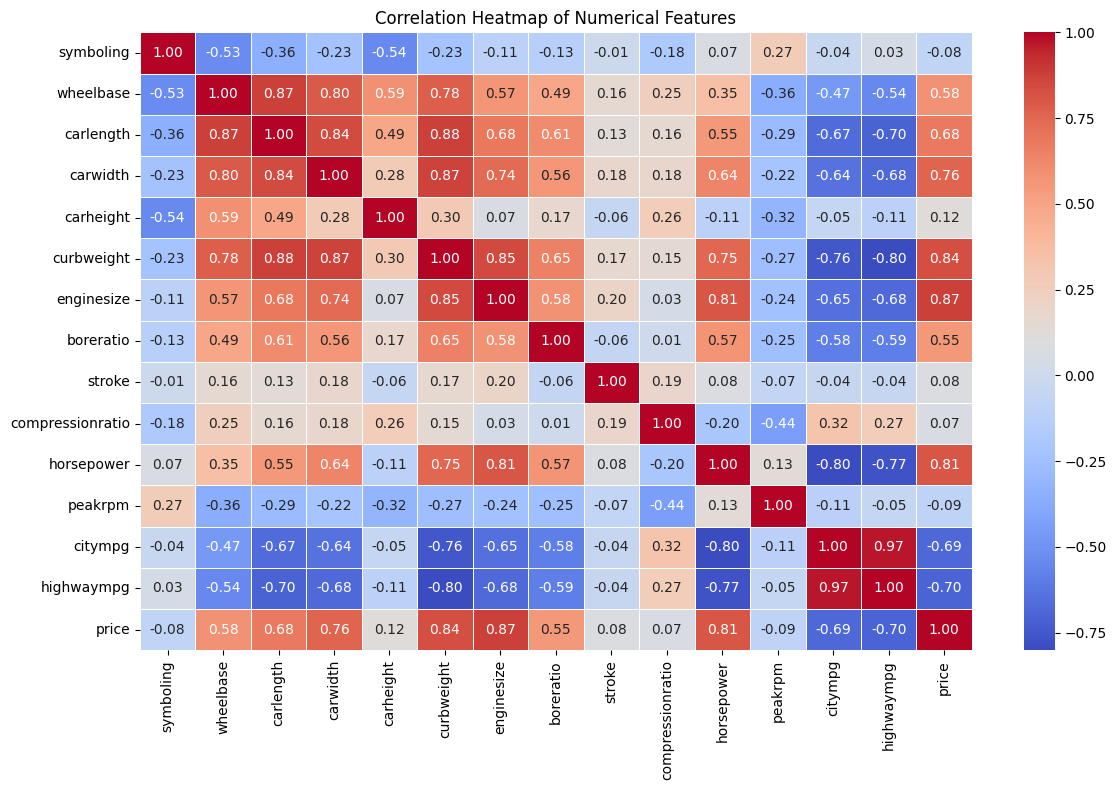

In [6]:
# Select numerical columns including target
numerical_cols = car_data.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numerical_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

According to above correlation bar graph and heat map it is evident that:
enginesize, curbweight, horsepower and carwidth are strongest positive contributors
Whereas, negatively contributing features include fuel efficiency- Highwaympg and Citympg.

Also, heatmap reveals multi collinearity between some features- 
enginesize and horsepower (0.81)
curbweight and carwidth (0.87)
citympg and highwaympg  (0.97)


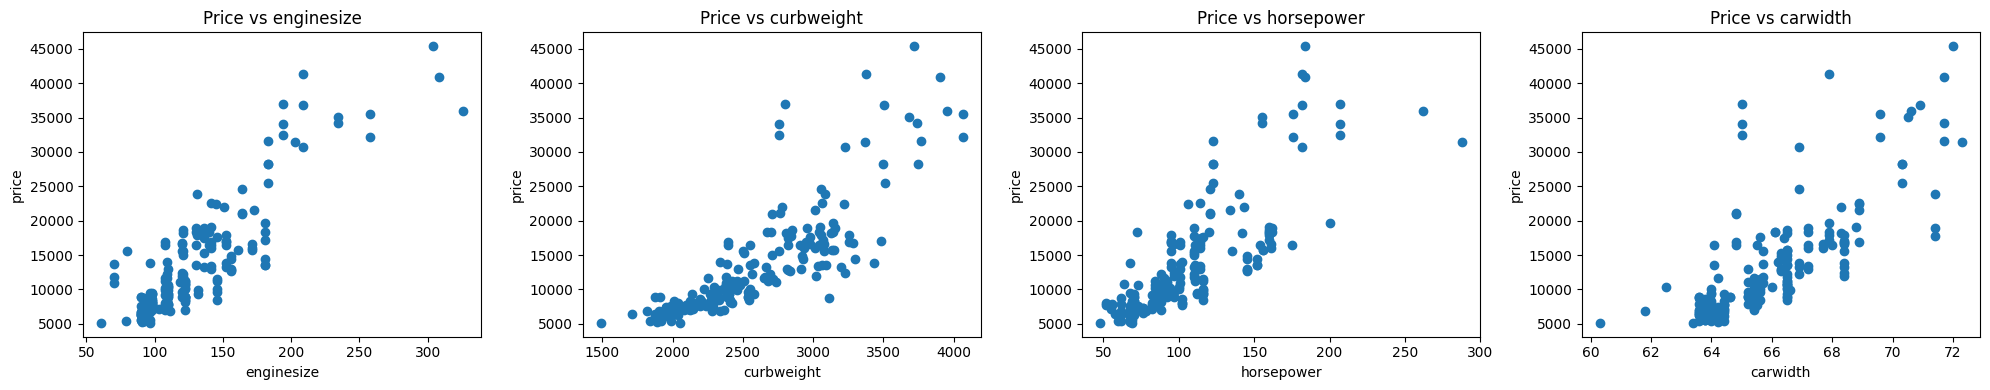

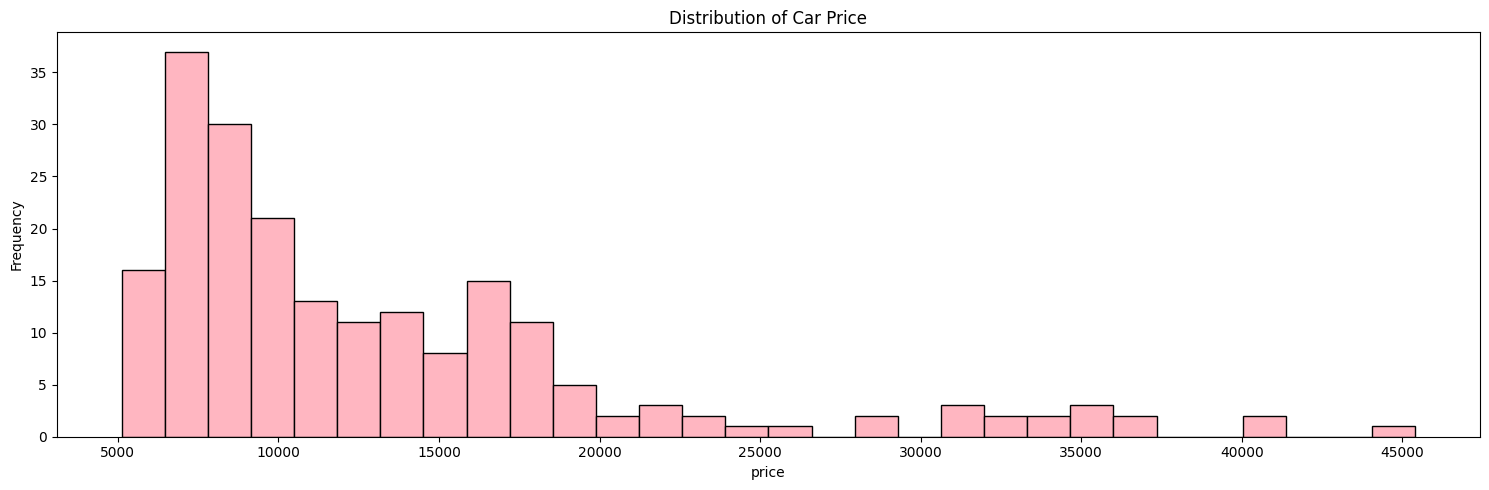

In [7]:
# Scatter plots: price vs top correlated Numeric features
top_features = ['enginesize', 'curbweight', 'horsepower', 'carwidth']
fig, axes = plt.subplots(1, len(top_features), figsize=(20, 4))

#Arranging plots in a single row#
for i, feature in enumerate(top_features):
    axes[i].scatter(car_data[feature], car_data['price'])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('price')
    axes[i].set_title(f'Price vs {feature}')

plt.tight_layout()
plt.show()

# Target distribution
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.hist(car_data['price'], bins=30, color='lightpink', edgecolor='black')
ax.set_xlabel('price')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Car Price')

plt.tight_layout()
plt.show()


The target distribution is right-skewed, which is expected because lower the price higher the selling in real-worl scenario and higher the price car is more luxurious

1.3 Checking correlation for Categorical values

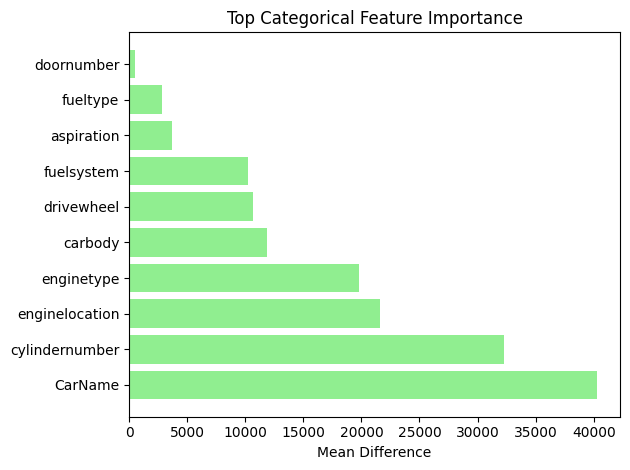

In [8]:
# Check important categorical features using mean differences


feature_importance = []
for feature in ['CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']:
    #Group by a categorical feature
    means = car_data.groupby(feature)['price'].mean()
    #Compute the mean difference
    mean_diff = means.max() - means.min()
    feature_importance.append((feature, mean_diff))

feature_importance.sort(key=lambda x: x[1], reverse=True)
features, importances = zip(*feature_importance)

plt.barh(range(len(features)), importances, color='lightgreen')
plt.yticks(range(len(features)), features)
plt.title('Top Categorical Feature Importance')
plt.xlabel('Mean Difference')

plt.tight_layout()
plt.show()

Note: Luxury cars are hard to predict as the price is too high and the frequency is less but it is important to keep this feature as in the real world scenario luxury cars are expensive.

# 2. Define Features and Split Data

In [9]:
#Calculate total feature sets#

numerical_features = [
    'symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
    'curbweight', 'enginesize', 'boreratio', 'stroke',
    'compressionratio', 'horsepower', 'peakrpm',
    'citympg', 'highwaympg'
]
categorical_features = [
    'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody',
    'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber',
    'fuelsystem'
]
print(" Feature Sets Defined:")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Separate features and target
X = car_data.drop(columns=['price'])
y = car_data['price']

# Split data into training and testing sets(80-20 split)#
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\n Data Split Complete:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

 Feature Sets Defined:
Numerical features: 14
Categorical features: 10

 Data Split Complete:
Training set: 164 samples
Test set: 41 samples
Features: 24


# 3. Create Preprocessing Pipelines

In [10]:
# Create preprocessing pipelines
print(" Creating Preprocessing Pipelines...")

# Numerical pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline  
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Main preprocessor
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

print(" Preprocessing pipelines created successfully!")

 Creating Preprocessing Pipelines...
 Preprocessing pipelines created successfully!


# 4.  Define and Setup Models, setting hyperparameter grids

In [11]:
# PHASE 1:  MODELS Setup
# ================================

print("🚀 Phase 1: Setting Up Regression Models")
print("=" * 70)

models = {
    'RandomForest': {
        'estimator': RandomForestRegressor(random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2],
            'model__max_features': ['sqrt', 'log2']
        }
    },

    'GradientBoosting': {
        'estimator': GradientBoostingRegressor(random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 4],
            'model__subsample': [0.8, 1.0]
        }
    },

    'Ridge': {
        'estimator': Ridge(random_state=42),
        'param_grid': {
            'model__alpha': [0.1, 1.0, 10.0]
        }
    },

    'Lasso': {
        'estimator': Lasso(random_state=42, max_iter=10000),
        'param_grid': {
            'model__alpha': [0.1, 1.0, 10.0]
        }
    },

    'SVR': {
        'estimator': SVR(),
        'param_grid': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale']
        }
    }
}


print(f"✅ {len(models)} models configured for training")


🚀 Phase 1: Setting Up Regression Models
✅ 5 models configured for training


## 5. Train and evaluate models


In [12]:
##build pipelines → train with GridSearchCV → evaluate → select best model → save it.
# PHASE 2: MODEL TRAINING & EVALUATION

print("🎯 Starting Model Training and Evaluation...")
print("=" * 70)

best_models = {}
results = []

for model_name, model_info in models.items():
    print(f"\n📊 Training {model_name}...")
    
    # Create pipeline that prevents data leakage
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_info['estimator'])
    ])
    
    # Grid search with CV
    # 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=model_info['param_grid'],
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    # Train (ONLY on training data)
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    
    # Predict on test data
    y_pred = best_model.predict(X_test)
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV_RMSE': -grid_search.best_score_
    })
    
    print(f"✅ {model_name} completed")
    print(f"   Best CV RMSE: {-grid_search.best_score_:.4f}")
    print(f"   Test RMSE  : {rmse:.4f}")
    print(f"   Test R²    : {r2:.4f}")

# Results summary
results_df = pd.DataFrame(results).sort_values(by='RMSE')

print("\n🏆 FINAL RESULTS COMPARISON")
display(results_df[['Model', 'R2', 'RMSE', 'MAE', 'CV_RMSE']].round(4))


🎯 Starting Model Training and Evaluation...

📊 Training RandomForest...
✅ RandomForest completed
   Best CV RMSE: 2559.3444
   Test RMSE  : 2811.7389
   Test R²    : 0.8999

📊 Training GradientBoosting...
✅ GradientBoosting completed
   Best CV RMSE: 2334.6599
   Test RMSE  : 2166.1764
   Test R²    : 0.9406

📊 Training Ridge...
✅ Ridge completed
   Best CV RMSE: 2641.2976
   Test RMSE  : 3149.5255
   Test R²    : 0.8743

📊 Training Lasso...
✅ Lasso completed
   Best CV RMSE: 2883.7038
   Test RMSE  : 3342.0328
   Test R²    : 0.8585

📊 Training SVR...
✅ SVR completed
   Best CV RMSE: 5011.2441
   Test RMSE  : 5695.2325
   Test R²    : 0.5891

🏆 FINAL RESULTS COMPARISON


,Model,R2,RMSE,MAE,CV_RMSE
1,GradientBoosting,0.9406,2166.1764,1613.5113,2334.6599
0,RandomForest,0.8999,2811.7389,1672.3972,2559.3444
2,Ridge,0.8743,3149.5255,2043.4601,2641.2976
3,Lasso,0.8585,3342.0328,2131.6179,2883.7038
4,SVR,0.5891,5695.2325,3167.2027,5011.2441


# 6. Select and Analyze Best Model

🏆 BEST MODEL: GradientBoosting
R² Score : 0.9406
RMSE     : 2166.18
MAE      : 1613.51


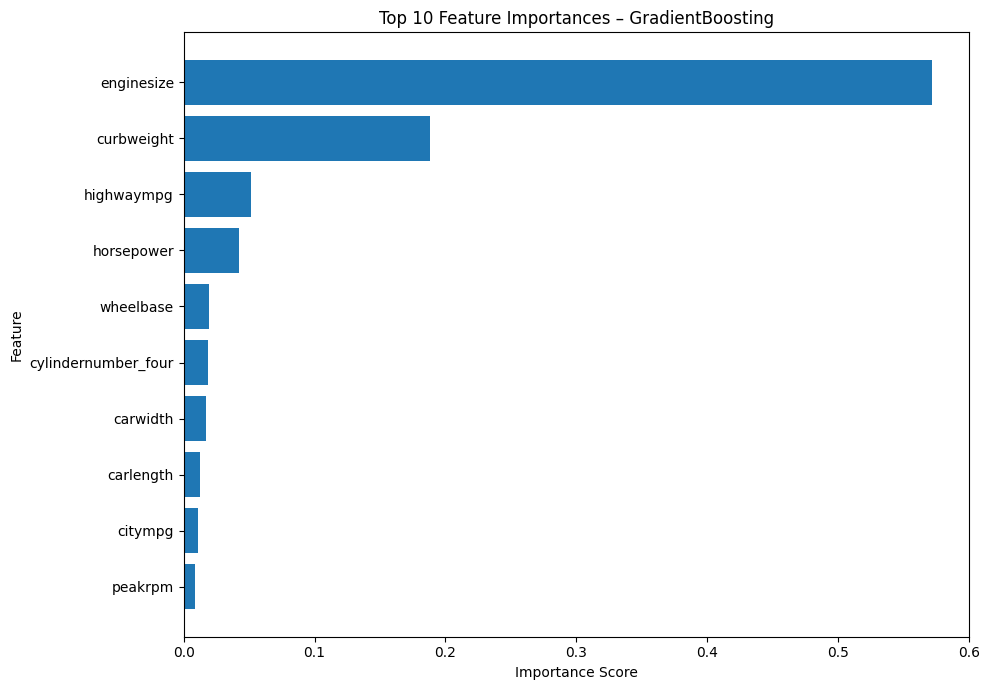


🔍 Top 10 Most Important Features:


,Feature,Importance
6,enginesize,0.571732
5,curbweight,0.188353
13,highwaympg,0.051363
10,horsepower,0.042352
1,wheelbase,0.019002
161,cylindernumber_four,0.018734
3,carwidth,0.017071
2,carlength,0.012849
12,citympg,0.010757
11,peakrpm,0.008866


In [13]:
# Phase 3 Select best model based on the evaluation metrics

best_model_name = results_df.iloc[0]['Model']
best_model = best_models[best_model_name]

row = results_df[results_df['Model'] == best_model_name].iloc[0]

print(f"🏆 BEST MODEL: {best_model_name}")
print(f"R² Score : {row['R2']:.4f}")
print(f"RMSE     : {row['RMSE']:.2f}")
print(f"MAE      : {row['MAE']:.2f}")


# Access preprocessor that has numerical and categorical features
preprocessor = best_model.named_steps['preprocessor']

# Numerical feature 
num_features = numerical_features

# Categorical feature  after OneHotEncoding
cat_transformer = preprocessor.named_transformers_['cat']
ohe = cat_transformer.named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_features)

# Combining all features
all_features = list(num_features) + list(cat_features)

# Get feature importances from Gradient Boosting
importances = best_model.named_steps['model'].feature_importances_

# Create DataFrame
feature_importance_df = (
    pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    })
    .sort_values(by='Importance', ascending=False)
)


# Plot the important features

plt.figure(figsize=(10, 7))
top_features = feature_importance_df.head(10)

plt.barh(top_features['Feature'], top_features['Importance'])
plt.gca().invert_yaxis()
plt.title(f'Top 10 Feature Importances – {best_model_name}')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n🔍 Top 10 Most Important Features:")
display(feature_importance_df.head(10))

# Above data interpretation:
Gradient boosting (94%) is the best model for predicting car prices in this dataset, achieving the lowest RMSE and highest R² score among the evaluated models.

The most important features for prediction in the given dataset is engine size, contributiong almost 58% , followed by weight of the car
